In [1]:
import warnings; warnings.filterwarnings('ignore')

import itertools
import time
import copy
import numpy as np
from pprint import pprint
from itertools import cycle

import gymnasium as gym
from gridworld.envs import SiblingGridWorldEnv
from gymnasium.envs.registration import register
from gymnasium.wrappers import TimeLimit
import seaborn as sns
from tabulate import tabulate
import tqdm as tqdm

import torch
from torch.utils.tensorboard import SummaryWriter

import random
import matplotlib
import matplotlib.pyplot as plt
# plt.style.use('fivethirtyeight')
params = {
    'figure.figsize': (15, 8),
    'font.size': 24,
    'legend.fontsize': 20,
    'axes.titlesize': 28,
    'axes.labelsize': 24,
    'xtick.labelsize': 20,
    'ytick.labelsize': 20
}
plt.rcParams.update(params)
np.set_printoptions(precision=3, suppress=True)
# plt.rcdefaults()

%matplotlib inline

from utils import *
from sibling_gw_agent import SiblingGWAgent

## Define the Sibling Grid World environment

In [2]:
def sibling():
    env = SiblingGridWorldEnv(P_gridworld)
    env = TimeLimit(env, max_episode_steps=100)
#     env = RelativePositionenv)
    return env

register(
    id='SiblingGridWorld-v0',
    entry_point=sibling,
    max_episode_steps=100,
)

env = gym.make('SiblingGridWorld-v0')
env = env.unwrapped
 #env.render_mode = 'human'
obs, info = env.reset(options={'randomize_world': True})

## Define the Sibling Grid World agent

In [3]:
n_episodes = 1
agent = SiblingGWAgent(env, gamma=1.0, 
            init_alpha=0.5, min_alpha=0.05, alpha_decay_ratio=0.5, 
            init_epsilon=1.0, min_epsilon=0.1, epsilon_decay_ratio=0.9, 
            n_episodes=n_episodes)

In [71]:
for episode in tqdm(range(agent.episode, agent.episode + n_episodes)):
    agent.reset()
    Q_bandit = [copy.deepcopy(agent.Q_bandit)]
    state, info = env.reset(options={'randomize_world': True})
    agent.episode = episode
    done = False

    while not done:
        #action = agent.select_action(state)
        action = agent.custom_action(state)
        next_state, reward, terminated, truncated, info = env.step(action)
        
        # update the agent
        agent.update(state, action, reward, terminated, next_state)
        Q_bandit += [copy.deepcopy(agent.Q_bandit)]

        # update if the environment is done or truncated
        done = terminated or truncated
        state = next_state

env.close()
Q_bandit = np.stack(Q_bandit, axis=1)
print(f"Environment solved in {env.num_moves} moves.")

100%|██████████| 1/1 [00:00<00:00, 216.15it/s]

Environment solved in 6 moves.


In [72]:
max_value = np.max(Q_bandit[:,-1])
max_indices = np.where(Q_bandit[:,-1] == max_value)[0]
print(f"True world: {env._true_world_idx}")
print(f"Agent's best worlds: {max_indices}")
print(f"Agent's world belief: {agent.env._world_belief[0]}")
print(f"Agent's graylist: {agent.graylist}")

True world: 16
Agent's best worlds: [ 6  7  8  9 10 12 13 14 15 16]
Agent's world belief: 8
Agent's graylist: {6, 7, 12, 13}


Text(0, 0.5, 'Bandit scores')

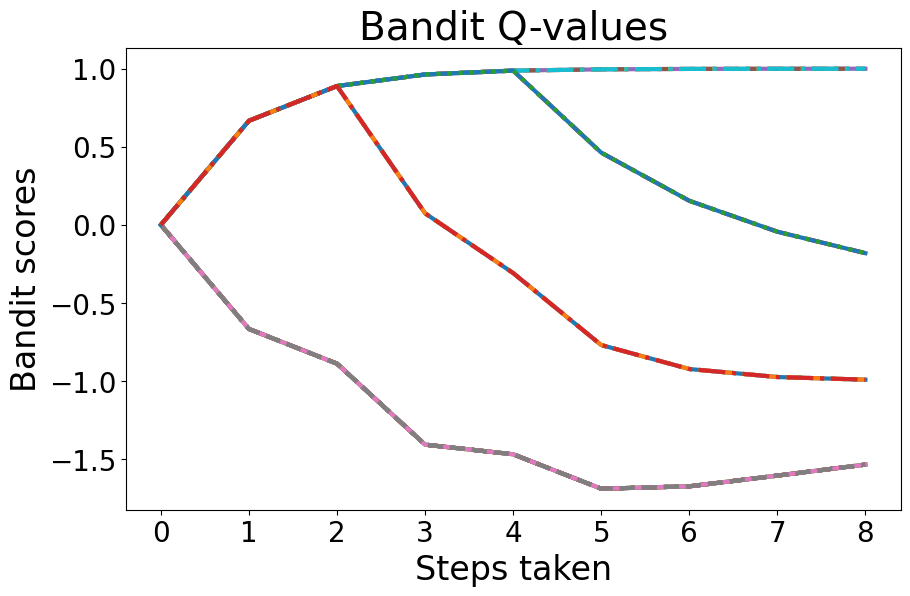

In [8]:
lines = ["-","--",":","-."]
linecycler = cycle(lines)

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
for i in range(24):
    ln = next(linecycler)
    ax.plot(calc_ewma(Q_bandit[i,:], env.num_moves/4), ln, linewidth=3)
    # ax.plot(Q_bandit[i,:], ln, linewidth=3)
ax.set_title("Bandit Q-values")
ax.set_xlabel("Steps taken")
ax.set_ylabel("Bandit scores")
# fig.savefig("../TeX/robot_on_chessboard/english_v2/figures/bandit_scores.eps", format="eps", dpi=1000, bbox_inches='tight', pad_inches=0.1)

In [7]:
rng = np.random.default_rng()
obs, info = env.reset(options={'randomize_world': True})
# env.render_mode = 'human'
agent.reset()

n_episodes = 50_000
avg_steps = np.zeros(n_episodes+1, dtype=np.float32)
avg_steps[0] = 7
alpha = 1e-3
running_avg = np.zeros(n_episodes+1, dtype=np.float32)
running_avg[0] = 7
state_count = np.zeros((5, 5), dtype=int)
all_steps = np.zeros(n_episodes, dtype=int)
all_bad_moves = np.zeros(n_episodes, dtype=int)
avg_bad_moves = 2
for e in tqdm(range(n_episodes)):
    obs, info = env.reset(options={'randomize_world': True})
    agent.reset()
    done = False
    while not done:
        # time.sleep(0.5)
        state_count[*obs] += 1
        action = agent.custom_action(obs)
        next_obs, rew, term, trunc, info = env.step(action)
        
        agent.update(obs, action, rew, term, next_obs)

        done = term or trunc
        obs = next_obs

        if done:
            state_count[*obs] += 1
            all_steps[e] = env.num_moves
            all_bad_moves[e] = env.bad_moves
            avg_bad_moves += 1/(e+1) * (env.bad_moves - avg_bad_moves)
            avg_steps[e+1] = avg_steps[e] + 1/(e+1) * (env.num_moves - avg_steps[e])
            running_avg[e+1] = ewma(running_avg[e], avg_steps[e+1], alpha)
            # time.sleep(0.5)
            break

state_count[2,2] -= n_episodes
print(f"Average steps: {avg_steps[-1]}; Average bad moves:{avg_bad_moves}",)
# time.sleep(2)
env.close()

100%|██████████| 50000/50000 [03:28<00:00, 239.33it/s]

Average steps: 6.662540435791016; Average bad moves:1.331279999999986


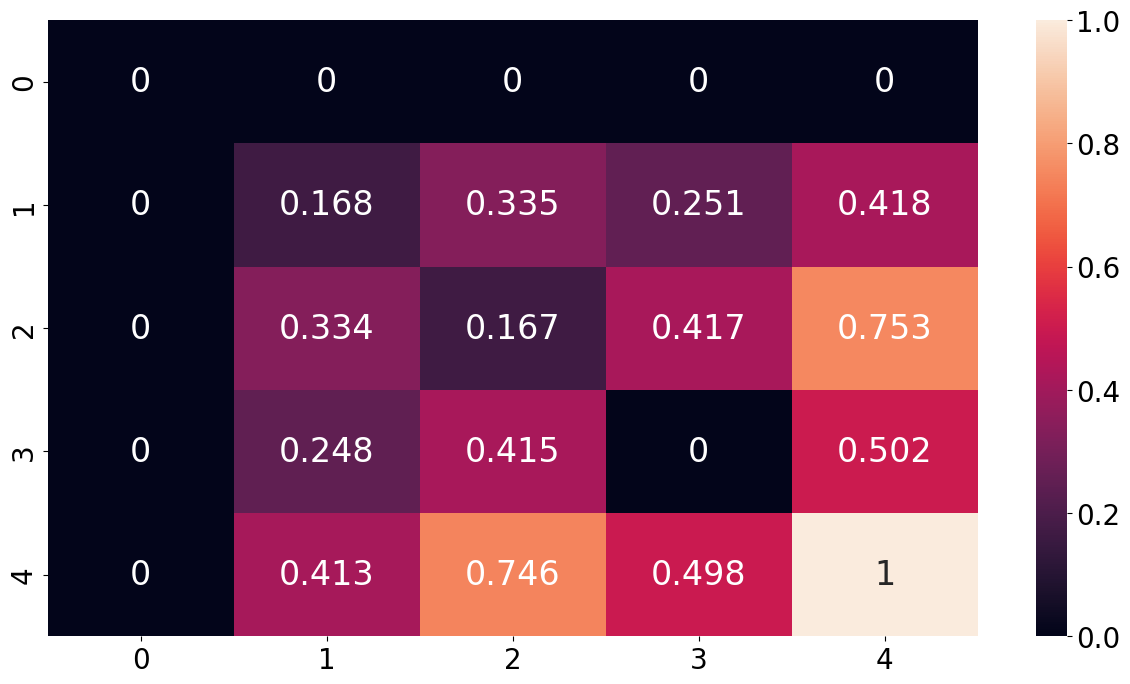

In [8]:
fig = plt.figure()
ax = fig.add_subplot(111)
sns.heatmap(state_count/n_episodes, annot=True, fmt='.3g', ax=ax)
# fig.savefig("../TeX/robot_on_chessboard/english_v2/figures/visit_count_ratio.eps", format="eps", dpi=1000, bbox_inches='tight', pad_inches=0.1)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


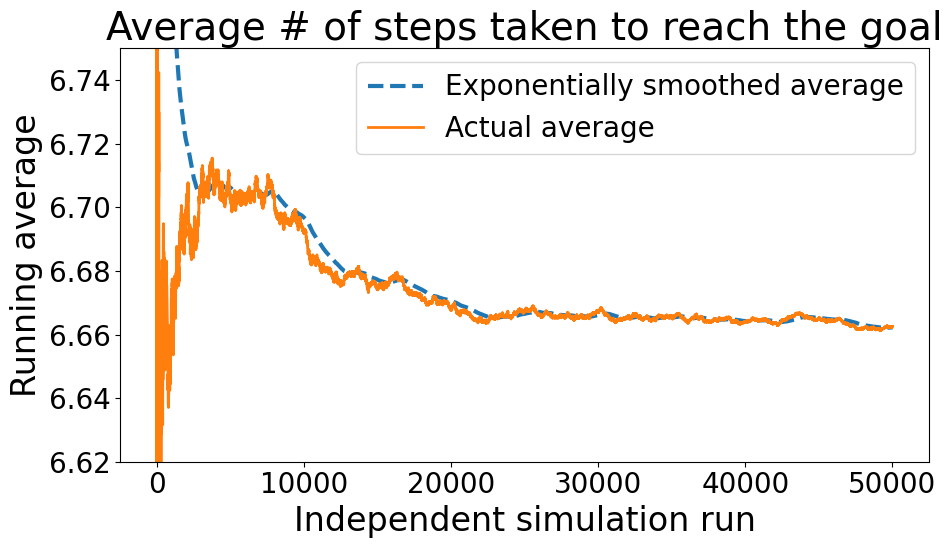

In [9]:
episodes = np.arange(0, n_episodes+1, step=1)
head = 10_0

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
ax.plot(episodes, running_avg, linewidth=3, label="Exponentially smoothed average", linestyle="--")
ax.plot(episodes, avg_steps, linewidth=2, label="Actual average", )
ax.set_xticks(np.arange(0, n_episodes+1, step=10000))
ax.set_title("Average # of steps taken to reach the goal")
ax.set_xlabel("Independent simulation run")
ax.set_ylabel("Running average")
# ax.set_xlim(200_000, 750_000)
ax.set_ylim(6.62, 6.75)
plt.legend(loc="best")
fig.tight_layout()
# fig.savefig("../TeX/robot_on_chessboard/english_v2/figures/running_avg.eps", format="eps", dpi=1000, bbox_inches='tight', pad_inches=0.1)

In [10]:
print(np.bincount(all_bad_moves) / np.sum(np.bincount(all_bad_moves)))
np.bincount(all_steps) / np.sum(np.bincount(all_steps))

[0.167 0.334 0.499]


array([0.   , 0.   , 0.   , 0.   , 0.167, 0.   , 0.334, 0.   , 0.499])

In [11]:
all_steps

array([6, 8, 4, ..., 6, 6, 8])

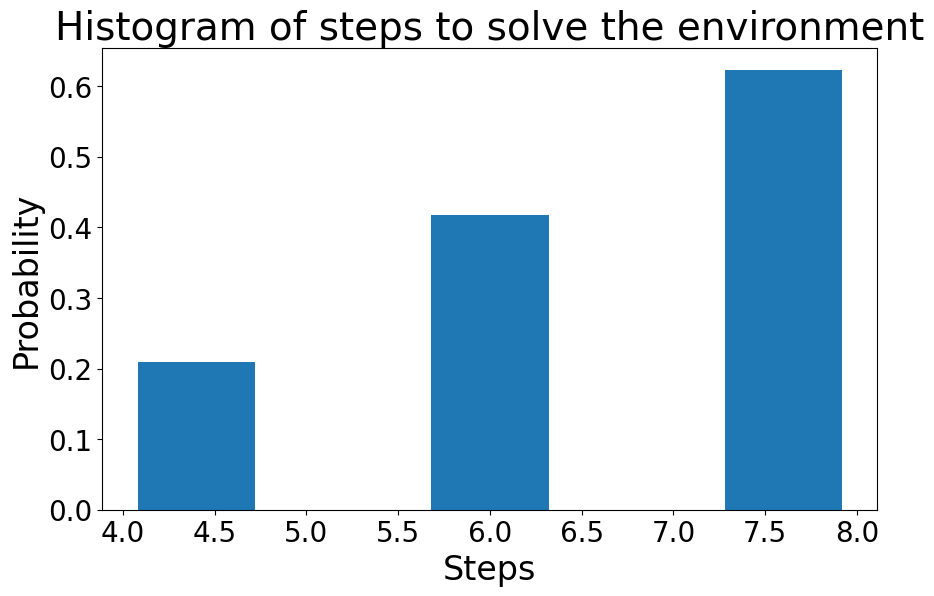

In [14]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
ax.hist(all_steps, bins=5, rwidth=0.8, density=True)
ax.set_title("Histogram of steps to solve the environment")
ax.set_xlabel("Steps")
ax.set_ylabel("Probability")
# fig.savefig("../TeX/robot_on_chessboard/english_v2/figures/steps_histogram.eps", format="eps", dpi=1000, bbox_inches='tight', pad_inches=0.1)

(array([ 8370.,     0., 16696.,     0., 24934.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. ]),
 <BarContainer object of 5 artists>)

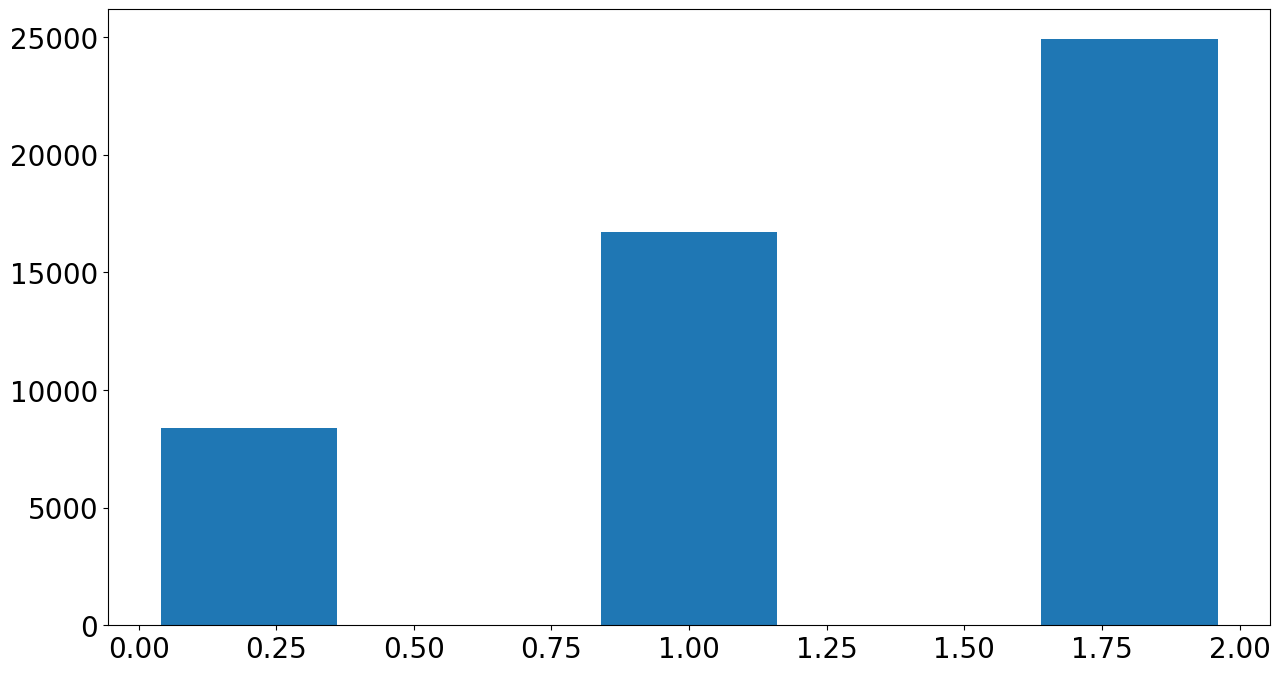

In [13]:
plt.hist(all_bad_moves, bins=5, rwidth=0.8)